Extract feature from TVDN. 

Here I fix U from SC

In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.colors import qual_cmap
from pyTVDN.TVDNclass_SC import TVDNSCDetect

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [5]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind 

def _get_test_tb(res_df):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    HC = res_df["metric"][res_df["diagnosis"]==6]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    for diag_ix in range(1, 6):
        DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
        ttest_res = ttest_ind(DS, HC)
        effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
        tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
    
    # pool 5 diseases together
    DS = res_df["metric"][res_df["diagnosis"]!=6]
    ttest_res = ttest_ind(DS, HC)
    effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}Dementia vs HC", 
                f"{ttest_res.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    
    # anova
    metric_grp = [res_df["metric"][res_df["diagnosis"]==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    tb.add_row([f"{indicator(anova_res.pvalue)}ANOVA", 
                f"{anova_res.pvalue:>6.3f}", 
                f""])
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb

In [6]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [7]:
# load data
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");

# some parameters

num_rois = 246 # the BNA has 246 regions
num_sps = 321
ac_time = 485

<AxesSubplot:>

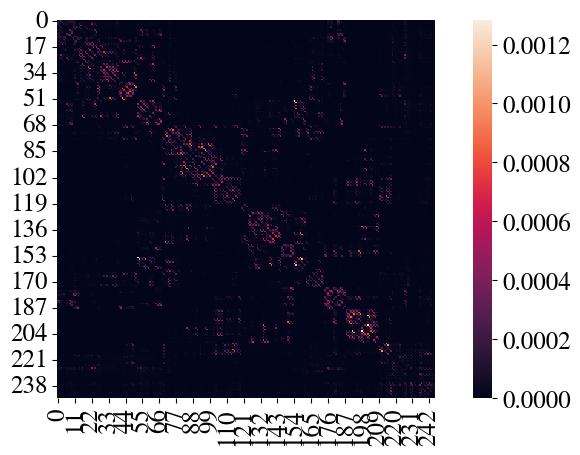

In [8]:
sc_mat = loadmat(DATA_ROOT/"SC_HC_BN_template_nature_order.mat")["SC_template"]
eigVals, eigVecs = np.linalg.eig(sc_mat)
sns.heatmap(sc_mat, square=True)

# Run TVDN

In [27]:
tvdn_paras = edict()
# these one are most influential
tvdn_paras.lamb = 1e-8
# r is moderately influential
tvdn_paras.r = 0.3 
# not very important
tvdn_paras.Lmin = 10
tvdn_paras.MaxM = 15

tvdn_paras.kappas = np.linspace(1, 3, 100)


## Get results


In [9]:
def _run_fn(sub_ix):
    ts = _load_data(sub_ix)[:num_rois]
    ts = _preprocess_ts(ts)
    det = TVDNSCDetect(Ymat=ts,
                     eigVals=eigVals, 
                     eigVecs=eigVecs,
                     showProgress=False,
                     saveDir=RES_ROOT/"tvdnsc_res",
                     fName=f"sub_{sub_ix}",
                     dataType="fMRI", 
                     MaxM=tvdn_paras.MaxM, 
                     Lmin=tvdn_paras.Lmin, 
                     lamb=tvdn_paras.lamb, 
                     r=tvdn_paras.r); 
    #det.Screening(wh=5)
    det()
    det.TuningKappa(tvdn_paras.kappas)
    det.UpdateEcpts()
    return det


In [ ]:
with Parallel(n_jobs=15) as parallel:
    res = parallel(delayed(_run_fn)(sub_ix) for sub_ix in tqdm(range(1, num_sps+1), total=num_sps))

## Kappa find

In [31]:
def _run_fn(sub_ix):
    ts = _load_data(sub_ix)[:num_rois]
    ts = _preprocess_ts(ts)
    det = TVDNSCDetect(Ymat=ts,
                     eigVals=eigVals, 
                     eigVecs=eigVecs,
                     showProgress=False,
                     saveDir=RES_ROOT/"tvdnsc_res",
                     fName=f"sub_{sub_ix}",
                     dataType="fMRI", 
                     MaxM=tvdn_paras.MaxM, 
                     Lmin=tvdn_paras.Lmin, 
                     lamb=tvdn_paras.lamb, 
                     r=tvdn_paras.r); 
    #det.Screening(wh=5)
    det()
    det.TuningKappa(tvdn_paras.kappas)
    det.UpdateEcpts()
    return det


In [32]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
mmse_scores = mat_data["mmse_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

In [33]:
numchgss = []
for sub_ix in tqdm(np.where(diag_labs==6)[0]):
    det = _run_fn(sub_ix)
    numchgss.append(det.numchgs)
numchgss = np.array(numchgss);

  0%|                                                                                                                                                  | 0/100 [00:00<?, ?it/s]/MyResearch/jesse_data/notebooks/../mypkg/pyTVDN/TVDNclass_SC.py:317: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 88.12it/s]


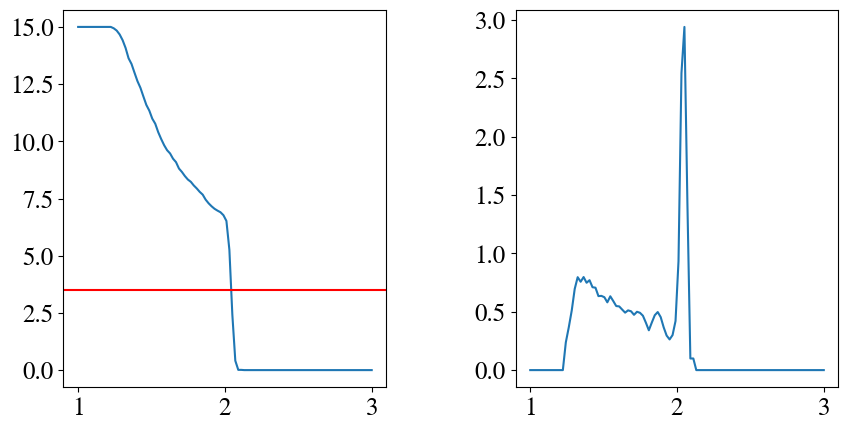

In [34]:
plt.subplot(121)
plt.plot(tvdn_paras.kappas, numchgss.mean(axis=0))
plt.axhline(y=3.5, color="red")
plt.subplot(122)
plt.plot(tvdn_paras.kappas, numchgss.std(axis=0))

The optimal kp is 1.949.


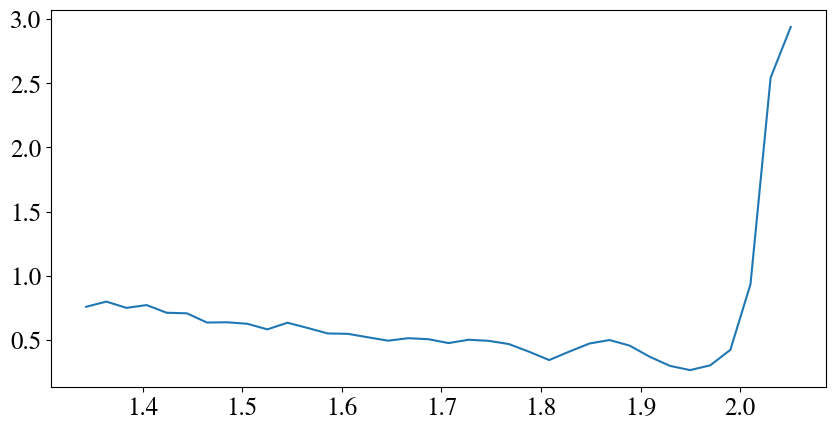

In [70]:
mcpts = numchgss.mean(axis=0)
stdcpts = numchgss.std(axis=0)
kpidxs = np.bitwise_and(mcpts<14, mcpts>1)
plt.plot(tvdn_paras.kappas[kpidxs], stdcpts[kpidxs])
optkp = tvdn_paras.kappas[kpidxs][np.argmin(stdcpts[kpidxs])]
print(f"The optimal kp is {optkp:.3f}.")

In [78]:
optkp = tvdn_paras.kappas[np.argmin(np.abs(numchgss.mean(axis=0)-12.5))]
print(f"The optimal kp is {optkp:.3f}.")

The optimal kp is 1.404.


## Get features

In [79]:
ecptss = []
for sub_ix in trange(1, num_sps+1):
    det = _run_fn(sub_ix)
    det.TuningKappa(tvdn_paras.kappas)
    det.UpdateEcpts(det.numchgs[tvdn_paras.kappas==optkp][0])
    ecptss.append(det.ecpts)
save_pkl(RES_ROOT/f"tvdnsc_ecptss_kp{optkp*1000:.0f}.pkl", ecptss, is_force=True)

  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]/MyResearch/jesse_data/notebooks/../mypkg/pyTVDN/TVDNclass_SC.py:317: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:05<00:00, 58.15it/s]

Save to /MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnsc_ecptss_kp1404.pkl


# Analyze

In [9]:
ecptss = load_pkl(RES_ROOT/f"tvdnsc_ecptss_kp1404.pkl")
ncpts = np.array([len(ecpts) for ecpts in ecptss])

Load file /MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnsc_ecptss_kp1404.pkl


In [11]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
mmse_scores = mat_data["mmse_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

In [12]:
res_df = pd.DataFrame({
    "metric": ncpts, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
_get_test_tb(res_df)

Test,Pval,Effect size
*AD vs HC,0.034,0.314
bvFTD vs HC,0.721,0.066
CBS vs HC,0.384,0.189
nfvPPA vs HC,0.601,0.104
svPPA vs HC,0.487,0.134
Dementia vs HC,0.105,0.195
ANOVA,0.423,


In [13]:
res_df.groupby("diagnosis1")["metric"].describe()

,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.865854,0.698538,11.0,12.0,13.0,13.0,14.0
CBS,27.0,12.777778,0.800641,11.0,12.0,13.0,13.0,15.0
HC,100.0,12.630000,0.774010,11.0,12.0,13.0,13.0,15.0
bvFTD,41.0,12.682927,0.849677,11.0,12.0,13.0,13.0,14.0
nfvPPA,34.0,12.705882,0.578892,11.0,12.0,13.0,13.0,14.0
svPPA,37.0,12.729730,0.651863,12.0,12.0,13.0,13.0,14.0
